In [2]:
import mujoco

In [3]:

# Compliant tendon parameter structure
class CompliantTendonParams:
    def __init__(self, F_max, l_opt, l_slack, v_max, W, C, N, K, E_REF):
        self.F_max = F_max
        self.l_opt = l_opt
        self.l_slack = l_slack
        self.v_max = v_max
        self.W = W
        self.C = C
        self.N = N
        self.K = K
        self.E_REF = E_REF
    def get_prm_str(self):
        return f"{self.F_max} {self.l_opt} {self.l_slack} {self.v_max} {self.W} {self.C} {self.N} {self.K} {self.E_REF}"

# Standard muscle parameter structure
# https://mujoco.readthedocs.io/en/stable/modeling.html#cmuscle
class DefaultParams:
    def __init__(self, range_min, range_max, force, scale, lmin, lmax, vmax, fpmax, fvmax):
        # muscle range: unit: l_opt
        self.range_min = range_min
        self.range_max = range_max
        # peak force(N)
        self.force = force
        # ignore
        self.scale = scale
        # active force min length; unit: l_opt
        self.lmin = lmin
        # active force max length; unit: l_opt
        self.lmax = lmax
        # active force max shortening velocity; unit: l_opt/s
        self.vmax = vmax
        # passive force at max length(range_max); unit: 1(ratio to fmax)
        self.fpmax = fpmax
        # Active force generated at saturating lengthening velocity, unit: 1(ratio to fmax)
        self.fvmax = fvmax
    def get_prm_str(self):
        return f"{self.range_min} {self.range_max} {self.force} {self.scale} {self.lmin} {self.lmax} {self.vmax} {self.fpmax} {self.fvmax}"




In [4]:
def create_model(cp_params:CompliantTendonParams, default_params:DefaultParams):
    xml_string = f"""
    <mujoco model="compliant_muscle_test">
    <!-- cmtu_integrator: Euler, RK4, ODE15s -->
    <option timestep="0.001" gravity="0 0 -9.81" integrator="Euler"/>

    <default>
        <!-- Compliant muscle default class -->
        <!-- F_max, l_opt, l_slack, v_max, W, C, N, K, E_REF -->
        <default class="compliant_muscle">
        <general biasprm="0" biastype="none" ctrllimited="true" ctrlrange="0 1" 
                dynprm="0.01 0.04" dyntype="muscle" 
                gainprm="{cp_params.get_prm_str()}" 
                gaintype="compliant_mtu"/>
        </default>
        
        <!-- Standard muscle for comparison -->
        <default class="standard_muscle">

        <!-- range(2), force, scale, lmin, lmax, vmax, fpmax, fvmax -->
        <general biasprm="{default_params.get_prm_str()}"
                ctrllimited="true" ctrlrange="0 1" 
                dynprm="0.01 0.04 0 0 0 0 0 0 0 0" dyntype="muscle" 
                gainprm="{default_params.get_prm_str()}"
                gaintype="muscle"/>
        </default>
    </default>

    <worldbody>
        <body name="ground"/>
        
        <!-- Fixed anchor sites for tendons -->
        <site name="fixed_c" pos="-0.15 0 0.24" size="0.005" rgba="0 0 1 1"/>
        <site name="fixed_r" pos="0.15 0 0.24" size="0.005" rgba="0 1 0 1"/>

        <!-- Point masses to be pulled by muscles -->
        <body name="mass_c" pos="-0.15 0 0.24">
        <joint name="slide_c" type="slide" axis="0 0 1" limited="false" range="-1 0.0" damping="0"/>
        <site name="mass_c_site" pos="0 0 0" size="0.005" rgba="0 0 1 1"/>
        <geom type="sphere" size="0.01" mass="10.0" rgba="0 0 1 1"/>
        </body>
        <body name="mass_r" pos="0.15 0 0.24">
        <joint name="slide_r" type="slide" axis="0 0 1" limited="false" range="-1 0.0" damping="0" />
        <site name="mass_r_site" pos="0 0 0" size="0.005" rgba="0 1 0 1"/>
        <geom type="sphere" size="0.01" mass="10.0" rgba="0 1 0 1"/>
        </body>
    </worldbody>

    <!-- Tendon paths for muscles: fixed anchor to point mass site -->
    <tendon>
        <spatial name="tendon_c">
        <site site="fixed_c"/>
        <site site="mass_c_site"/>
        </spatial>
        <spatial name="tendon_r">
        <site site="fixed_r"/>
        <site site="mass_r_site"/>
        </spatial>
    </tendon>

    <actuator>
        <!-- Compliant muscle pulling left point mass -->
        <general class="compliant_muscle" name="compliant_muscle_c" tendon="tendon_c"/>
        
        <!-- Standard muscle pulling right point mass (for comparison) -->
        <muscle class="standard_muscle" name="standard_muscle_r" tendon="tendon_r" 
                lengthrange="0.0575158 0.156738"/>
    </actuator>

    <sensor>
        <!-- Tendon length sensors -->
        <tendonpos name="len_c" tendon="tendon_c"/>
        <tendonpos name="len_r" tendon="tendon_r"/>
        
        <!-- Actuator force sensors -->
        <actuatorfrc name="frc_c" actuator="compliant_muscle_c"/>
        <actuatorfrc name="frc_r" actuator="standard_muscle_r"/>
        
        <!-- Joint position sensors -->
        <jointpos name="pos_c" joint="slide_c"/>
        <jointpos name="pos_r" joint="slide_r"/>
        
        <!-- Joint velocity sensors -->
        <jointvel name="vel_c" joint="slide_c"/>
        <jointvel name="vel_r" joint="slide_r"/>
    </sensor>
    </mujoco>
    """

    model = mujoco.MjModel.from_xml_string(xml_string)

    return model

1. fitting range
2. 

In [5]:
cp_params = CompliantTendonParams(1500, 0.11, 0.13, 12.0, 0.56, -2.995732274, 1.5, 5.0, 0.04)
default_params = DefaultParams(0.1, 0.5, 1500, 1, 0, 1.99579, 10, 1.86621, 1.4)
model = create_model(cp_params, default_params)
data = mujoco.MjData(model)


In [11]:

H, W = 480, 640
renderer = mujoco.Renderer(model, height=H, width=W)
ctx = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
frame = renderer.render()

model.opt.timestep = 1/1200
mujoco.mj_resetData(model, data)

episode_count = 10

datas_by_vel = []

frames = []
for episode in range(episode_count):
    datas = {}

    for ui in range(model.nu):
        datas[f'ctrl_{ui}'] = []
    for ji in range(model.njnt):
        datas[f'qpos_{ji}'] = []
    for ji in range(model.njnt):
        datas[f'qvel_{ji}'] = []
    for fi in range(model.nu):
        datas[f'frc_{fi}'] = []
    # Log activation as well
    for ai in range(model.nu):
        datas[f'activation_{ai}'] = []

    mujoco.mj_resetData(model, data)
    vel = 0.1 * episode
    if vel > 0:
        data.joint("slide_c").qpos = -0.3
        data.joint("slide_r").qpos = -0.3
    data.joint("slide_c").qvel = vel
    data.joint("slide_r").qvel = vel
    mujoco.mj_fwdVelocity(model, data)
    mujoco.mj_forward(model, data)
    mujoco.mj_fwdActuation(model, data)
    for idx in range(100):
        for simulation_step in range(40):
            data.joint("slide_c").qpos += vel * model.opt.timestep
            data.joint("slide_c").qvel = vel
            data.joint("slide_r").qpos += vel * model.opt.timestep
            data.joint("slide_r").qvel = vel

            data.act[:] = 0.0
            # mujoco.mj_step(model, data)
            mujoco.mj_fwdVelocity(model, data)
            mujoco.mj_forward(model, data)
            mujoco.mj_fwdActuation(model, data)

            # collect data
            for ui in range(model.nu):
                datas[f'ctrl_{ui}'].append(data.ctrl[ui])
            for ji in range(model.njnt):
                datas[f'qpos_{ji}'].append(data.qpos[ji])
            for ji in range(model.njnt):
                datas[f'qvel_{ji}'].append(data.qvel[ji])
            for fi in range(model.nu):
                datas[f'frc_{fi}'].append(data.qfrc_actuator[fi])
            for ai in range(model.nu):
                datas[f'activation_{ai}'].append(data.act[ai])
            if data.joint("slide_c").qpos > -0.1:
                break

        renderer.update_scene(data)
        frame = renderer.render()
        frames.append(frame.copy())  # Important: copy the frame!

        if data.joint("slide_c").qpos > -0.1:
            break

    datas_by_vel.append(datas)

renderer.close()


In [12]:
import imageio
video_path = "dummy.mp4"
imageio.mimsave(video_path, frames, fps=30)
from IPython.display import Video, display
display(Video(video_path, embed=True))

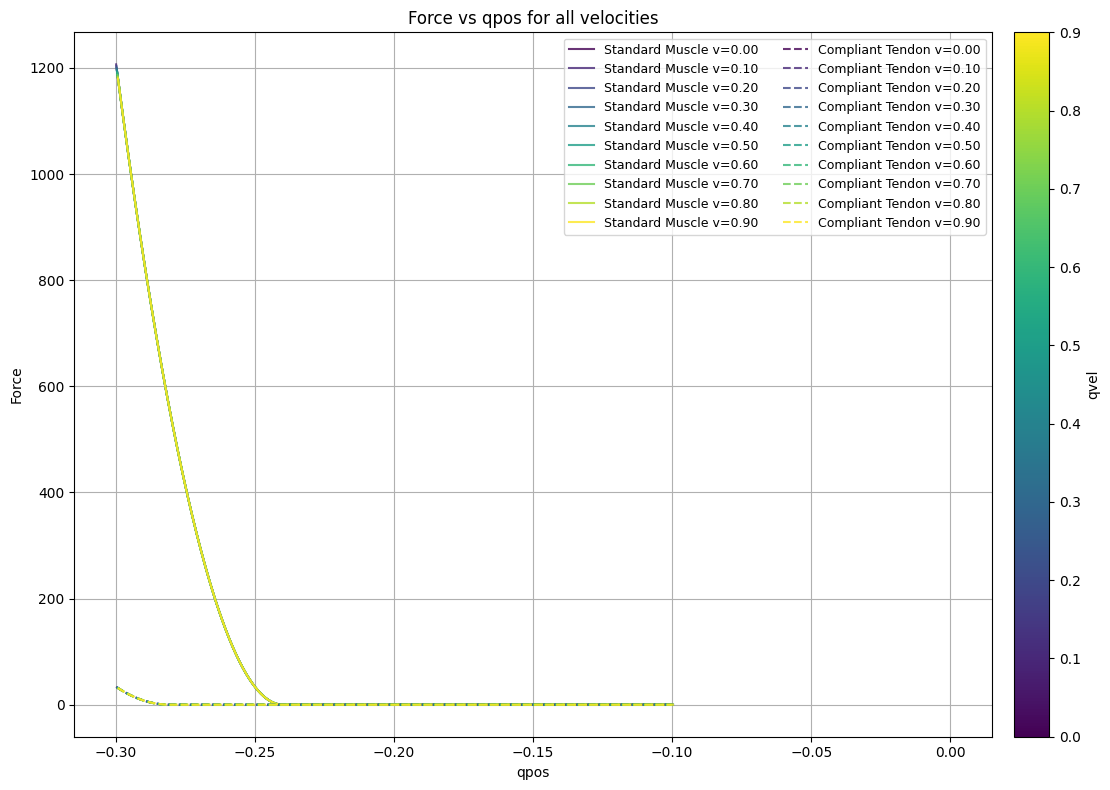

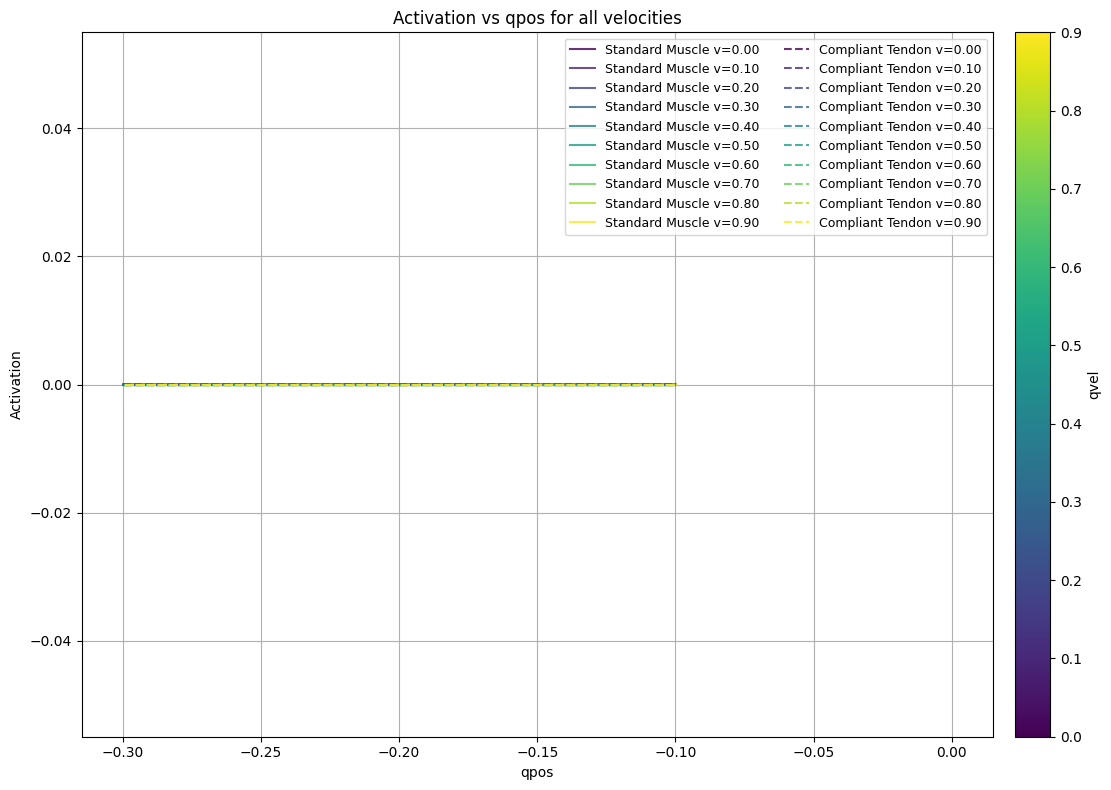

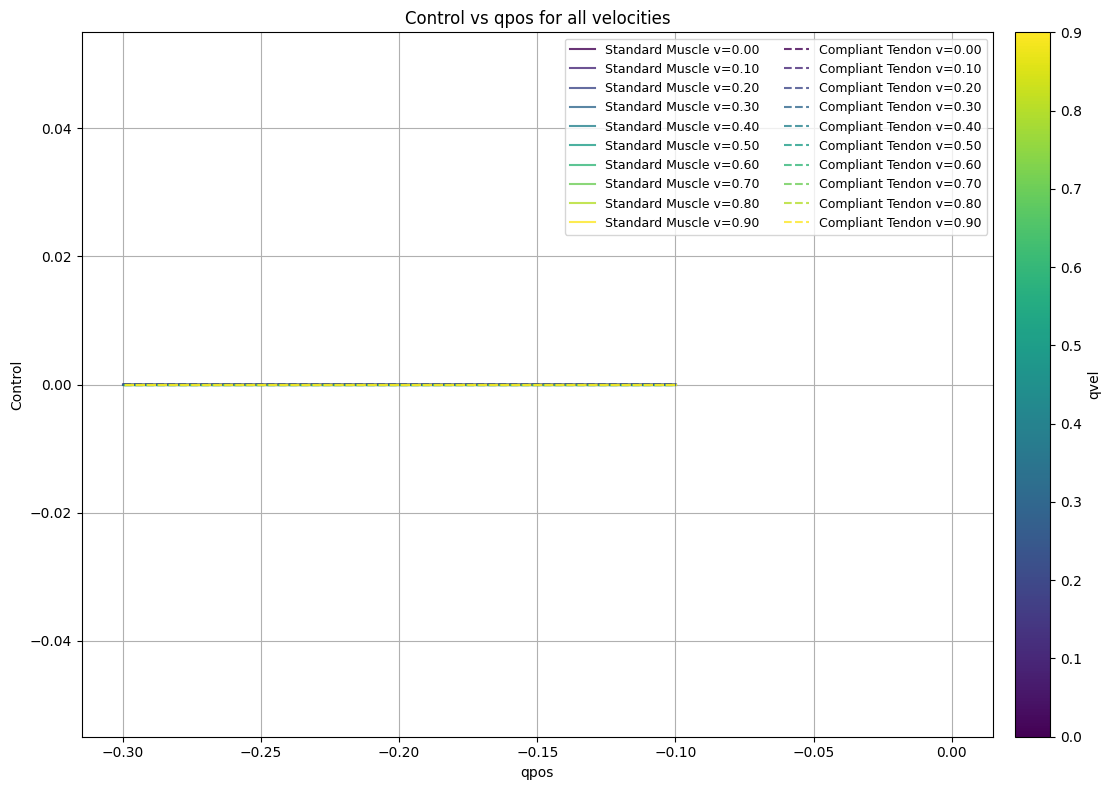

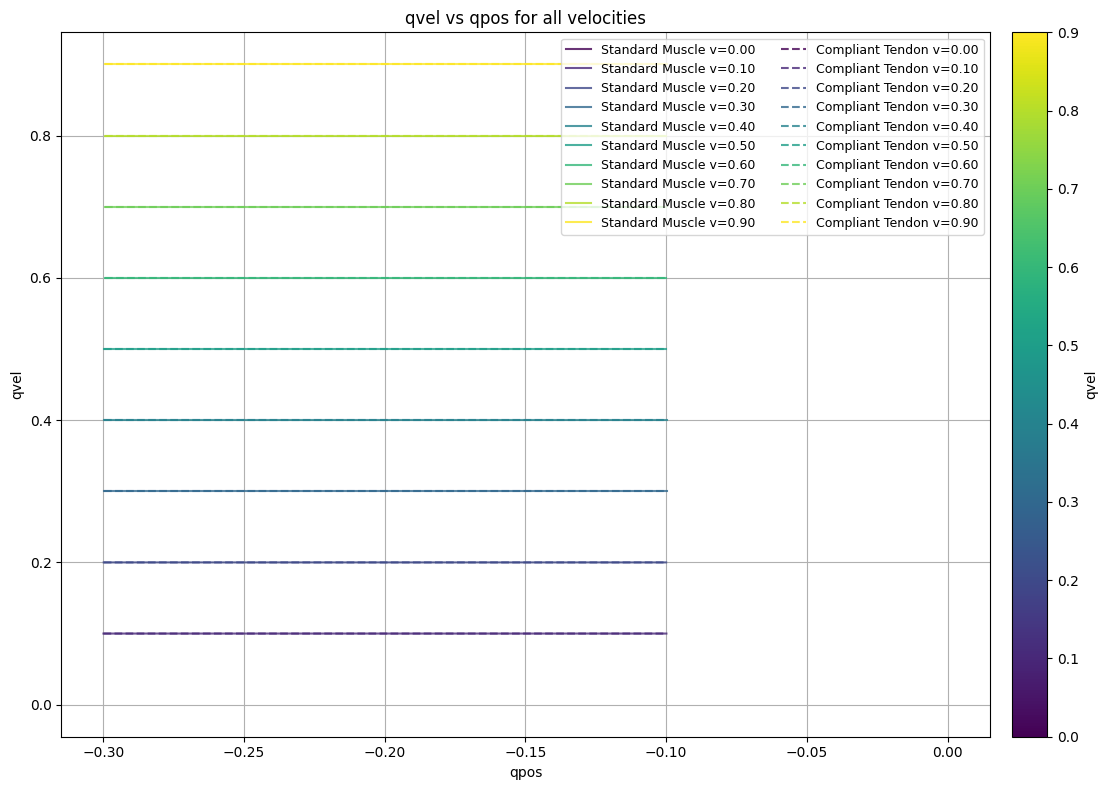

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# There are 10 episodes (velocities), data is stored per episode in datas_by_vel
episode_count = len(datas_by_vel)
# Each episode uses velocity = 0.1 * episode
velocities = [0.1 * i for i in range(episode_count)]

# actuator 0: standard muscle, actuator 1: compliant tendon
actuator_info = {
    0: {'label': 'Standard Muscle', 'color': 'blue', 'linestyle': '-'},
    1: {'label': 'Compliant Tendon', 'color': 'red', 'linestyle': '--'}
}

def plot_all_episodes_on_one_graph(xkey, ykey, ylabel, title):
    """
    Draw all episodes (different velocities) on one graph for both actuators.
    X-axis is qpos, Y-axis is ykey.
    The two actuators are shown with different color/linestyle and every episode uses a separate colormap for line colors.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    # Prepare a color map for different velocities
    color_map = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(velocities), vmax=max(velocities))

    lines = []
    labels = []
    for ai in [0, 1]:
        for ep in range(episode_count):
            datas = datas_by_vel[ep]
            x = np.array(datas[f"{xkey}_{ai}"])
            y = np.array(datas[f"{ykey}_{ai}"])
            line_color = color_map(norm(velocities[ep]))
            line, = ax.plot(
                x, y,
                color=line_color,
                linestyle=actuator_info[ai]['linestyle'],
                alpha=0.8,
                label=f"{actuator_info[ai]['label']} v={velocities[ep]:.2f}"
            )
            # For custom legend handling (use only one color for actuator, but show all velocities in color map)
            lines.append(line)
            labels.append(f"{actuator_info[ai]['label']} v={velocities[ep]:.2f}")

    ax.set_xlabel("qpos")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    # Make legend for all lines (ai * episode_count)
    ax.legend(lines, labels, fontsize=9, loc='best', ncol=2)
    # Show velocity colorbar
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("qvel")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Force (frc) vs qpos
plot_all_episodes_on_one_graph("qpos", "frc", ylabel="Force", title="Force vs qpos for all velocities")

# Activation vs qpos
plot_all_episodes_on_one_graph("qpos", "activation", ylabel="Activation", title="Activation vs qpos for all velocities")

# Control vs qpos
plot_all_episodes_on_one_graph("qpos", "ctrl", ylabel="Control", title="Control vs qpos for all velocities")

# qvel vs qpos
plot_all_episodes_on_one_graph("qpos", "qvel", ylabel="qvel", title="qvel vs qpos for all velocities")


In [9]:
datas["ctrl_1"][1500:1510]

[]